/tmp/ipython-input-1816791779.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='intent', data=df, order=df['intent'].value_counts().index, palette='viridis')


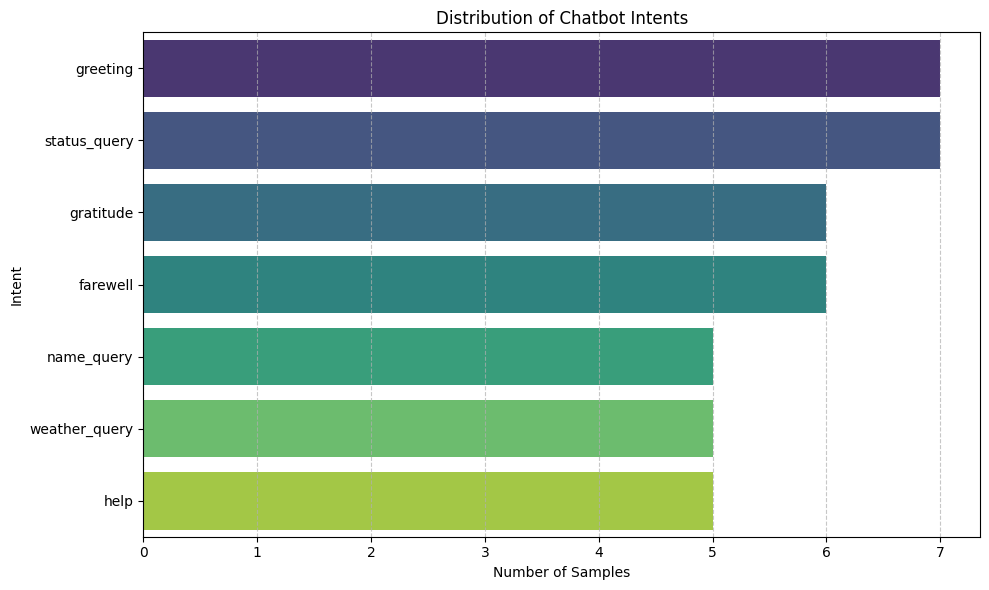


Accuracy on Test Set: 0.44

Classification Report:
               precision    recall  f1-score   support

     farewell       1.00      1.00      1.00         1
    gratitude       0.25      1.00      0.40         1
     greeting       1.00      0.50      0.67         2
         help       1.00      0.00      0.00         1
   name_query       0.33      1.00      0.50         1
 status_query       1.00      0.00      0.00         2
weather_query       1.00      0.00      0.00         1

     accuracy                           0.44         9
    macro avg       0.80      0.50      0.37         9
 weighted avg       0.84      0.44      0.36         9



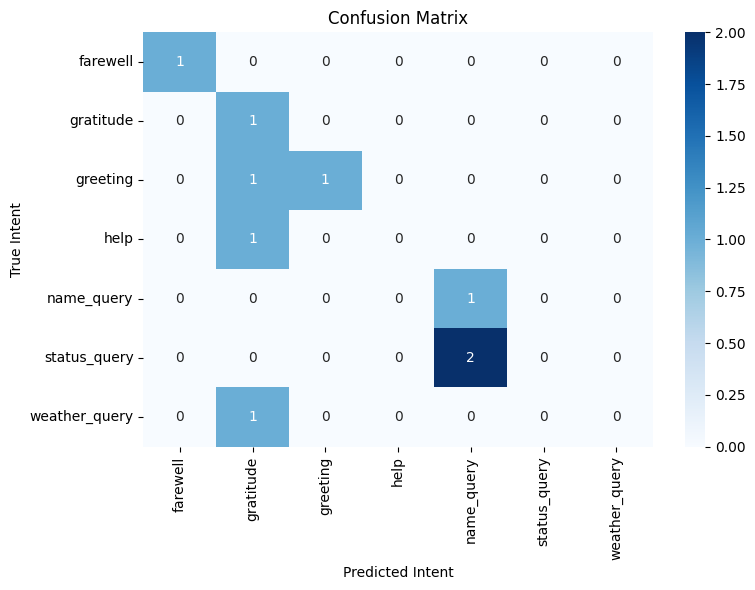


--- Chatbot Ready ---
Type 'quit' to exit.

You: Hello
Chatbot: Hi there!

You: What is your name?
Chatbot: I am a chatbot created to assist you.

You: Thanks
Chatbot: No problem!

You: Bye
Chatbot: See you soon!

You: What's the weather like?
Chatbot: I can't provide live weather updates, but you can check a weather app!



In [1]:
# --------------------------
# 1. Import Libraries
# --------------------------
import pandas as pd
import numpy as np
import random
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 2. Load the Dataset (Corrected & Balanced)
# --------------------------
data = {
    'text': [
        # Greetings
        "Hi there", "Hello", "Hey chatbot", "Good morning", "Howdy", "Good evening", "Good afternoon",

        # Status queries
        "How are you?", "What's up?", "How's it going?", "Are you good?", "How do you do?", "Feeling okay?", "What's new?",

        # Name queries
        "What is your name?", "Who are you?", "Do you have a name?", "Tell me your name", "Your name please",

        # Help queries
        "Help me please", "I need assistance", "Can you help?", "Support me", "I am stuck, need help",

        # Weather queries
        "What's the weather like?", "Is it raining?", "Give me weather forecast", "Temperature today", "Current weather",

        # Farewells
        "Bye", "Goodbye", "See you later", "Farewell", "Catch you later", "Good night",

        # Gratitude
        "Thank you", "Much appreciated", "Thanks a lot", "Cheers", "Many thanks", "Appreciate it"
    ],

    'intent': [
        # Greetings
        "greeting", "greeting", "greeting", "greeting", "greeting", "greeting", "greeting",

        # Status queries
        "status_query", "status_query", "status_query", "status_query", "status_query", "status_query", "status_query",

        # Name queries
        "name_query", "name_query", "name_query", "name_query", "name_query",

        # Help queries
        "help", "help", "help", "help", "help",

        # Weather queries
        "weather_query", "weather_query", "weather_query", "weather_query", "weather_query",

        # Farewells
        "farewell", "farewell", "farewell", "farewell", "farewell", "farewell",

        # Gratitude
        "gratitude", "gratitude", "gratitude", "gratitude", "gratitude", "gratitude"
    ]
}

df = pd.DataFrame(data)

# --------------------------
# 3. Data Preprocessing
# --------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)   # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Encode intents
le = LabelEncoder()
df['intent_encoded'] = le.fit_transform(df['intent'])

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# --------------------------
# 4. Data Visualization
# --------------------------
plt.figure(figsize=(10,6))
sns.countplot(y='intent', data=df, order=df['intent'].value_counts().index, palette='viridis')
plt.title('Distribution of Chatbot Intents')
plt.xlabel('Number of Samples')
plt.ylabel('Intent')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --------------------------
# 5. Splitting and Training
# --------------------------
X = X_tfidf
y = df['intent_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train, y_train)

# --------------------------
# 6. Evaluating the Model
# --------------------------
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on Test Set: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=1))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Intent')
plt.ylabel('True Intent')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --------------------------
# 7. Save the Model
# --------------------------
model_filename = 'intent_classifier_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'
label_encoder_filename = 'label_encoder.pkl'

joblib.dump(model, model_filename)
joblib.dump(tfidf_vectorizer, vectorizer_filename)
joblib.dump(le, label_encoder_filename)

# --------------------------
# 8. Load for Prediction
# --------------------------
try:
    loaded_model = joblib.load(model_filename)
    loaded_vectorizer = joblib.load(vectorizer_filename)
    loaded_le = joblib.load(label_encoder_filename)
except Exception as e:
    print(f"Error loading model files: {e}")
    exit()

def predict_intent(text):
    cleaned_text = clean_text(text)
    text_features = loaded_vectorizer.transform([cleaned_text])
    encoded_prediction = loaded_model.predict(text_features)[0]
    predicted_intent = loaded_le.inverse_transform([encoded_prediction])[0]
    return predicted_intent

# --------------------------
# 9. Chatbot Interaction (Works in Colab)
# --------------------------
print("\n--- Chatbot Ready ---")
print("Type 'quit' to exit.\n")

# In Colab, you can either use input() or test with a predefined list
test_mode = True   # Change to False if you want manual input()

if test_mode:
    test_sentences = ["Hello", "What is your name?", "Thanks", "Bye", "What's the weather like?"]

    for sentence in test_sentences:
        predicted_intent = predict_intent(sentence)

        if predicted_intent == 'greeting':
            response = random.choice(["Hello! How can I help you?", "Hi there!", "Greetings!"])
        elif predicted_intent == 'status_query':
            response = "I'm a program, so I don't have feelings, but I'm functioning perfectly!"
        elif predicted_intent == 'name_query':
            response = "I am a chatbot created to assist you."
        elif predicted_intent == 'help':
            response = "I can help you with general queries. What do you need?"
        elif predicted_intent == 'weather_query':
            response = "I can't provide live weather updates, but you can check a weather app!"
        elif predicted_intent == 'farewell':
            response = random.choice(["Goodbye!", "See you soon!", "Have a great day!"])
        elif predicted_intent == 'gratitude':
            response = random.choice(["You're welcome!", "Glad to help!", "No problem!"])
        else:
            response = "I'm not sure how to respond to that. Can you rephrase?"

        print(f"You: {sentence}")
        print(f"Chatbot: {response}\n")

else:
    while True:
        user_input = input("You: ").strip()
        if user_input.lower() == 'quit':
            print("Chatbot: Goodbye! Have a great day!")
            break

        predicted_intent = predict_intent(user_input)

        if predicted_intent == 'greeting':
            response = random.choice(["Hello! How can I help you?", "Hi there!", "Greetings!"])
        elif predicted_intent == 'status_query':
            response = "I'm a program, so I don't have feelings, but I'm functioning perfectly!"
        elif predicted_intent == 'name_query':
            response = "I am a chatbot created to assist you."
        elif predicted_intent == 'help':
            response = "I can help you with general queries. What do you need?"
        elif predicted_intent == 'weather_query':
            response = "I can't provide live weather updates, but you can check a weather app!"
        elif predicted_intent == 'farewell':
            response = random.choice(["Goodbye!", "See you soon!", "Have a great day!"])
        elif predicted_intent == 'gratitude':
            response = random.choice(["You're welcome!", "Glad to help!", "No problem!"])
        else:
            response = "I'm not sure how to respond to that. Can you rephrase?"

        print(f"Chatbot: {response}")
